In [1]:
# imports
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
# define date parser
d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# read csv file (set date column as index)
df = pd.read_csv(
    './data/energy-charts_Stromproduktion_und_Börsenstrompreise_in_Deutschland_2020_Excel.csv',
    sep=";", 
    parse_dates=['Datum (MT+1)'], 
    date_parser=d_parser
    # index_col='Datum (MT+1)'
)

In [3]:
# copy df to edit df
df_energy = df.copy()

# rename date column
df_energy.rename(columns={'Datum (MT+1)': 'datetime', 'Day Ahead Auktion (DE-LU)': 'energy_price', 'Nicht Erneuerbar': 'not_renewable', 'Kernenergie': 'nuclear_power', 'Erneuerbar': 'renewable' }, inplace=True)

In [4]:
# add Date column
df_energy['Date'] = df_energy['datetime'].dt.date

In [5]:
# add weekday column
df_energy['day_of_week'] = df_energy['datetime'].dt.day_name()

In [6]:
# remove import saldo column, as all values are NaN
df_energy = df_energy.dropna(axis=1, how="all")

In [7]:
# Check if there is any na value in df
df_energy.replace('na', np.nan, inplace=True)
df_energy.replace('NA', np.nan, inplace=True)
df_energy.replace('Missing', np.nan, inplace=True)
print(df_energy.isna().value_counts())

datetime  nuclear_power  not_renewable  renewable  energy_price  Date   day_of_week
False     False          False          False      False         False  False          35136
dtype: int64


In [8]:
# drop duplicates
df_energy.drop_duplicates(inplace=True)

In [9]:
df_energy.head(10)

,datetime,nuclear_power,not_renewable,renewable,energy_price,Date,day_of_week
0,2020-01-01 00:00:00,8089.585,29700.989,14524.769,38.60,2020-01-01,Wednesday
1,2020-01-01 00:15:00,8087.935,29597.398,14407.463,38.60,2020-01-01,Wednesday
2,2020-01-01 00:30:00,8088.635,29433.049,14537.378,38.60,2020-01-01,Wednesday
3,2020-01-01 00:45:00,8086.715,29319.558,14695.598,38.60,2020-01-01,Wednesday
4,2020-01-01 01:00:00,8093.394,29202.803,14902.589,36.55,2020-01-01,Wednesday
5,2020-01-01 01:15:00,8090.135,29144.575,14898.388,36.55,2020-01-01,Wednesday
6,2020-01-01 01:30:00,8076.207,29123.509,14975.325,36.55,2020-01-01,Wednesday
7,2020-01-01 01:45:00,8064.899,29243.764,15021.521,36.55,2020-01-01,Wednesday
8,2020-01-01 02:00:00,8080.356,29402.351,15004.099,32.32,2020-01-01,Wednesday
9,2020-01-01 02:15:00,8072.587,29418.973,14981.647,32.32,2020-01-01,Wednesday


In [10]:
df_energy.describe()

,nuclear_power,not_renewable,renewable,energy_price
count,35136.000000,35136.000000,35136.000000,35136.000000
mean,6934.673246,33765.069651,27962.757734,30.471738
std,969.703507,11159.545300,12106.069379,17.501029
min,3739.551000,11985.471000,7809.697000,-83.940000
25%,6450.204500,25593.516000,18140.908750,21.750000
50%,6793.422000,32771.112000,26610.473500,30.990000
75%,7834.915000,39948.887250,36752.224000,40.250000
max,8185.779000,68966.183000,69026.970000,200.040000


#### what does it mean when the price is minus?

>Negative Strompreise (oder sehr niedrige Strompreise) kommen im Großhandel dann vor, wenn ein Stromüberschuss besteht. Oder anders gesagt, wenn die Stromerzeugung den Stromverbrauch überschreitet. Eine solche Situation entsteht unter anderem, bei einer sehr hohen Einspeisung mit sehr preisgünstigem Strom aus Wind, wie das im Moment der Fall ist.
[agrarheute](https://www.agrarheute.com/markt/diesel/strompreise-fallen-neue-tiefstaende-stromkunden-gehen-leer-602385)

In [11]:
df_energy.loc[:,['nuclear_power', 'not_renewable', 'renewable', 'energy_price']].corr()

,nuclear_power,not_renewable,renewable,energy_price
nuclear_power,1.000000,0.407680,-0.135737,0.372776
not_renewable,0.407680,1.000000,-0.459684,0.796859
renewable,-0.135737,-0.459684,1.000000,-0.512600
energy_price,0.372776,0.796859,-0.512600,1.000000


### Analization - Day of week and Energy Price

In [12]:
# Name dataframe grouped by weekeday
grp_day_of_week = df_energy.groupby(['day_of_week'])

In [13]:
monday = grp_day_of_week.get_group('Monday')
monday

,datetime,nuclear_power,not_renewable,renewable,energy_price,Date,day_of_week
480,2020-01-06 00:00:00,7747.079,32613.952,25506.327,29.00,2020-01-06,Monday
481,2020-01-06 00:15:00,7765.926,32690.316,25194.688,29.00,2020-01-06,Monday
482,2020-01-06 00:30:00,7763.077,32732.358,25048.000,29.00,2020-01-06,Monday
483,2020-01-06 00:45:00,7745.940,32552.516,24946.564,29.00,2020-01-06,Monday
484,2020-01-06 01:00:00,7768.946,32700.959,24905.467,29.08,2020-01-06,Monday
...,...,...,...,...,...,...,...
34843,2020-12-28 22:45:00,8132.878,32297.707,14213.323,42.14,2020-12-28,Monday
34844,2020-12-28 23:00:00,8135.377,30775.400,14230.425,38.80,2020-12-28,Monday
34845,2020-12-28 23:15:00,8135.977,30408.404,14212.882,38.80,2020-12-28,Monday
34846,2020-12-28 23:30:00,8141.066,30291.036,14154.869,38.80,2020-12-28,Monday


In [14]:
list_day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
list_df_day_of_week = []

# create a data frame sorted by day_of_week
for day in list_day_of_week:
    df_name = day.lower()
    df_name = grp_day_of_week.get_group(day)
    list_df_day_of_week.append(df_name)

# after for loop, we should have a dataframe like below for each day_of_week.
# monday = grp_day_of_week.get_group('Monday')
monday

,datetime,nuclear_power,not_renewable,renewable,energy_price,Date,day_of_week
480,2020-01-06 00:00:00,7747.079,32613.952,25506.327,29.00,2020-01-06,Monday
481,2020-01-06 00:15:00,7765.926,32690.316,25194.688,29.00,2020-01-06,Monday
482,2020-01-06 00:30:00,7763.077,32732.358,25048.000,29.00,2020-01-06,Monday
483,2020-01-06 00:45:00,7745.940,32552.516,24946.564,29.00,2020-01-06,Monday
484,2020-01-06 01:00:00,7768.946,32700.959,24905.467,29.08,2020-01-06,Monday
...,...,...,...,...,...,...,...
34843,2020-12-28 22:45:00,8132.878,32297.707,14213.323,42.14,2020-12-28,Monday
34844,2020-12-28 23:00:00,8135.377,30775.400,14230.425,38.80,2020-12-28,Monday
34845,2020-12-28 23:15:00,8135.977,30408.404,14212.882,38.80,2020-12-28,Monday
34846,2020-12-28 23:30:00,8141.066,30291.036,14154.869,38.80,2020-12-28,Monday


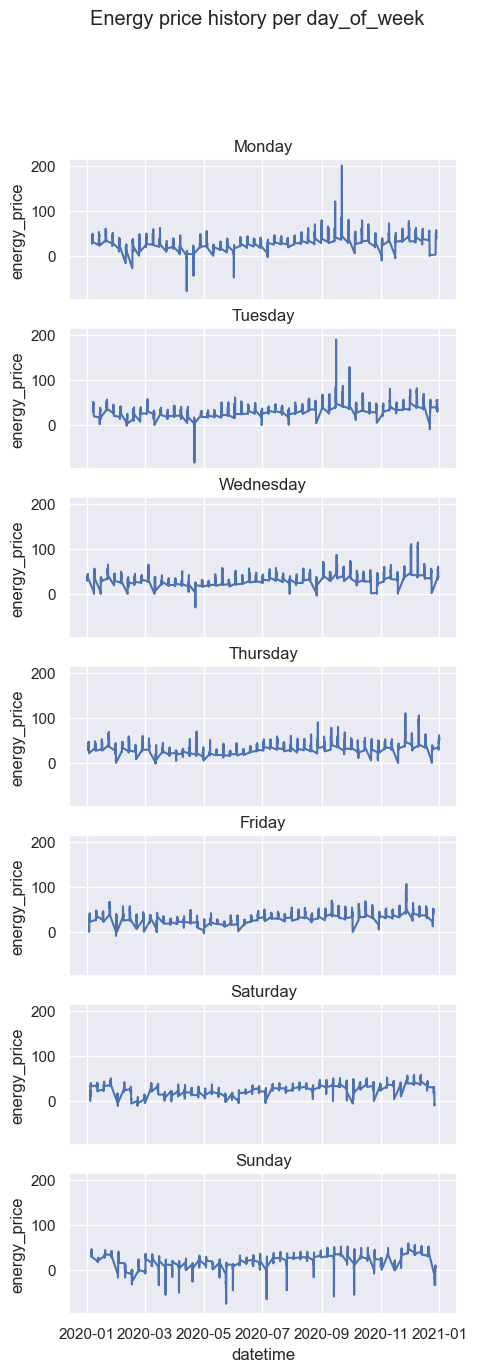

In [15]:
# set seaborn plotting aesthetics as default
sns.set()
# define plotting region (1 row, 7 columns)
fig, axes = plt.subplots(7, 1, sharex=True, sharey=True, figsize=(5, 15))
fig.suptitle('Energy price history per day_of_week')

for i, (day_name, df) in enumerate(zip(list_day_of_week, list_df_day_of_week)):
    sns.lineplot(x='datetime', y='energy_price', data=df, ax=axes[i])
    axes[i].set_title(day_name)
    
plt.show()

In [16]:
# Energy price grouped by day_of_week
desc = grp_day_of_week['energy_price'].describe()
# Add a column Q3 - Q1
desc['QD'] = (desc['75%'] - desc['25%']) / 2
# create a series of median and rename column
median = grp_day_of_week['energy_price'].median()
median.rename('median', inplace=True)

# merge extended description and median 
desc_with_med_and_qd = pd.merge(desc, median, on='day_of_week')
desc_with_med_and_qd.reindex(index=list_day_of_week)

,count,mean,std,min,25%,50%,75%,max,QD,median
day_of_week,,,,,,,,,,
Monday,4992.0,32.391106,18.979678,-78.15,22.6125,33.365,43.2925,200.04,10.34000,33.365
Tuesday,4992.0,33.767548,18.152121,-83.94,24.2775,33.000,42.4600,189.25,9.09125,33.000
Wednesday,5088.0,35.137555,15.999207,-29.98,25.5375,33.785,43.2300,114.00,8.84625,33.785
Thursday,5088.0,35.097586,14.358696,-1.58,25.7650,34.040,43.1850,110.13,8.71000,34.040
Friday,4992.0,33.382268,13.440421,-8.77,24.9200,33.595,41.2525,106.35,8.16625,33.595
Saturday,4992.0,25.210457,12.838657,-11.16,17.1250,26.260,34.0000,58.00,8.43750,26.260
Sunday,4992.0,18.136963,20.075361,-74.97,7.5700,21.445,32.0100,58.97,12.22000,21.445


- Energy price on weekend are lower than on weekdays
- Mean and median are almost the same -> the prices are more or less evenly distributed from the lowest to highest price
- Standard deviation and Q3 - Q1 for this case??

<AxesSubplot: xlabel='day_of_week', ylabel='energy_price'>

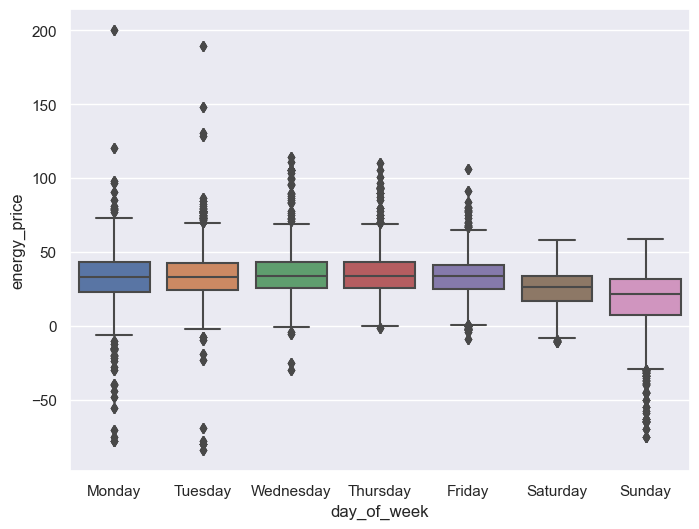

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x=df_energy['day_of_week'], 
    order=list_day_of_week, 
    y=df_energy['energy_price'] 
    )

- Monday and Tuesday have more outliers compared to the other weekdays -> Prediction for Monday and Tuesday would be more difficult than for other week days.
- Sunday has also relatively many outliers, but they are all lower than the average value
- Weekdays don't seem to have a crutial influence on the energy price.
- Energy price tends to decrease slightly on weekends.
- Energy price on Saturday seem to be most stable.

>Die Preisunterschiede an einem Tag sind unter der Woche stärker ausgeprägt als am Wochenende (einschließlich Feiertage). Von Montag bis Freitag liegen Höchst- und Tiefstpreise stärker auseinander als an Samstagen und Sonntagen. Der Grund dafür ist, dass viele Berufstätige am Wochenende nicht arbeiten und die Kinder zuhause sind. Wann dann etwa jede Familie morgens Kaffee oder Tee kocht, verteilt sich stärker über den Vormittag – an Wochentagen konzentriert sich das auf weniger Stunden am Morgen.
["Wann Du Strom verbrauchst, ist entscheidend für seinen Preis" - finanztip.de](https://www.finanztip.de/stromtarife/variable-stromtarife/)

### Analization -  Energy feeding volume and day of week

In [18]:
# add total energy feeding column
#? nuclear power included in not renewable energy?
df_energy['total_energy_feeding'] = df_energy['nuclear_power'] + df_energy['not_renewable'] + df_energy['renewable']

In [19]:
grp_day_of_week = grp_day_of_week = df_energy.groupby(['day_of_week'])

In [20]:
grp_day_of_week['total_energy_feeding'].describe()

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,4992.0,69917.491386,12549.746954,42872.523,59873.86050,71069.7630,79565.27875,98751.726
Monday,4992.0,69918.247473,12239.264902,41207.345,60322.93700,70101.9400,79165.95925,98430.497
Saturday,4992.0,63356.519742,10602.921242,40311.080,54518.64850,64541.1690,71981.47675,85536.094
Sunday,4992.0,61656.717454,9854.759566,36223.006,53961.33400,62577.9965,68871.60650,87678.034
Thursday,5088.0,71422.509517,12226.575670,36914.398,61858.21525,71880.6695,81748.56975,98271.865
Tuesday,4992.0,72161.785827,12311.460898,44509.947,62091.98100,73424.3120,82150.08675,99247.990
Wednesday,5088.0,72085.332241,12017.922367,39435.459,62248.95900,73154.0215,81952.63625,97988.101


In [21]:
# reshape df_energy
df_energy_reshape = df_energy.melt(['datetime', 'day_of_week', 'energy_price', 'Date'], var_name='type_of_power', value_name='feeding_volume')
df_energy_reshape

,datetime,day_of_week,energy_price,Date,type_of_power,feeding_volume
0,2020-01-01 00:00:00,Wednesday,38.60,2020-01-01,nuclear_power,8089.585
1,2020-01-01 00:15:00,Wednesday,38.60,2020-01-01,nuclear_power,8087.935
2,2020-01-01 00:30:00,Wednesday,38.60,2020-01-01,nuclear_power,8088.635
3,2020-01-01 00:45:00,Wednesday,38.60,2020-01-01,nuclear_power,8086.715
4,2020-01-01 01:00:00,Wednesday,36.55,2020-01-01,nuclear_power,8093.394
...,...,...,...,...,...,...
140539,2020-12-31 22:45:00,Thursday,52.26,2020-12-31,total_energy_feeding,56965.715
140540,2020-12-31 23:00:00,Thursday,50.87,2020-12-31,total_energy_feeding,55746.064
140541,2020-12-31 23:15:00,Thursday,50.87,2020-12-31,total_energy_feeding,55432.609
140542,2020-12-31 23:30:00,Thursday,50.87,2020-12-31,total_energy_feeding,55001.483


<AxesSubplot: xlabel='type_of_power', ylabel='feeding_volume'>

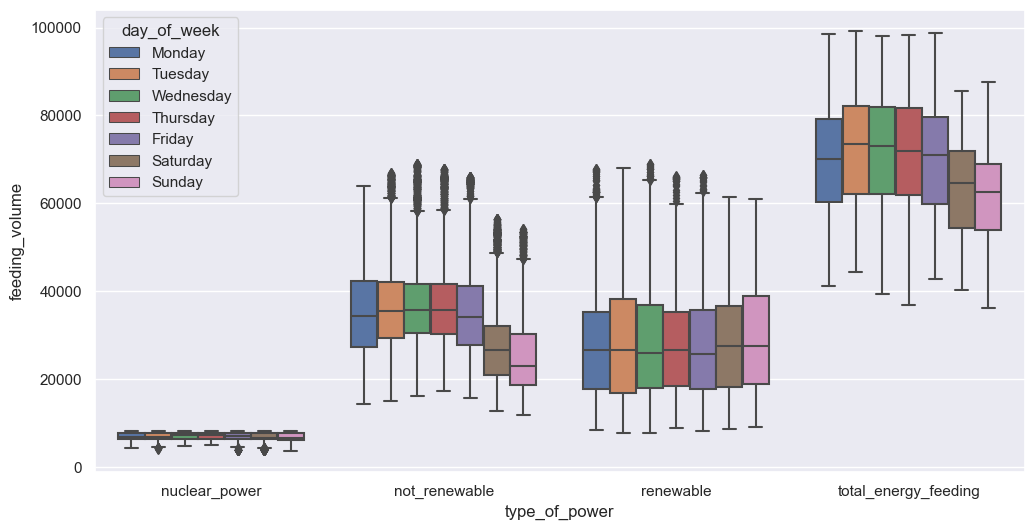

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_energy_reshape,
    x='type_of_power',
    y='feeding_volume',
    hue='day_of_week',
    hue_order=list_day_of_week
)

- No significant differences on feeding volume of nuclear power and renewable energy per day of week
- Feeding volume of not renewable energy is considerably less (by about 10.000 MW)
--> Total feeding volume of renewable energy is the same also on weekends, but the demand is less (refer to the article above), so that the feeding volume of not renewable energy becomes lower, which leads to the lower price.

Ref:
[Bruttostromerzeugung in Deutschland 2019-2022](https://www.destatis.de/DE/Themen/Branchen-Unternehmen/Energie/Erzeugung/Tabellen/bruttostromerzeugung.html)

In [23]:
# import wind data and create dataframe

df_wind = pd.read_csv(
    './data/energy-charts_Windgeschwindigkeit_in_Deutschland_im_Jahr_2020_Excel.csv',
    sep=';',
    parse_dates=['Date (UTC)'], 
    date_parser=d_parser,
    )

# Check if there is any na value in df
df_wind.replace('na', np.nan, inplace=True)
df_wind.replace('NA', np.nan, inplace=True)
df_wind.replace('Missing', np.nan, inplace=True)
print(df_wind.isna().value_counts())

# remove duplicates
df_wind.drop_duplicates()

df_wind.rename(columns={'Date (UTC)': 'datetime', 'Value': 'wind_speed'}, inplace=True)


Date (UTC)  Value
False       False    8784
dtype: int64


In [24]:
# import solar data and create dataframes

df_solar = pd.read_csv(
    './data/energy-charts_Globale_Solarstrahlung_in_Deutschland_im_Jahr_2020_Excel.csv',
    sep=';',
    parse_dates=['Date (UTC)'],
    date_parser=d_parser,
)
# Check if there is any na value in df
df_solar.replace('na', np.nan, inplace=True)
df_solar.replace('NA', np.nan, inplace=True)
df_solar.replace('Missing', np.nan, inplace=True)
print(df_solar.isna().value_counts())

df_solar.drop_duplicates()

df_solar.rename(columns={'Date (UTC)': 'datetime', 'Value': 'solar_radiation'}, inplace=True)

Date (UTC)  Value
False       False    8784
dtype: int64


In [25]:
# set datetime as index and merge df_wind and df_solar
# wind_speed = m/s
# solar_radiation = W/m2
df_climate = pd.merge(df_wind, df_solar)
df_climate['month'] = pd.DatetimeIndex(df_climate['datetime']).month
df_climate

,datetime,wind_speed,solar_radiation,month
0,2020-01-01 00:00:00,2.4,0,1
1,2020-01-01 01:00:00,2.4,0,1
2,2020-01-01 02:00:00,2.5,0,1
3,2020-01-01 03:00:00,2.4,0,1
4,2020-01-01 04:00:00,2.4,0,1
...,...,...,...,...
8779,2020-12-31 19:00:00,2.8,0,12
8780,2020-12-31 20:00:00,2.8,0,12
8781,2020-12-31 21:00:00,2.7,0,12
8782,2020-12-31 22:00:00,2.6,0,12


### Graph - Wind speed in 2020

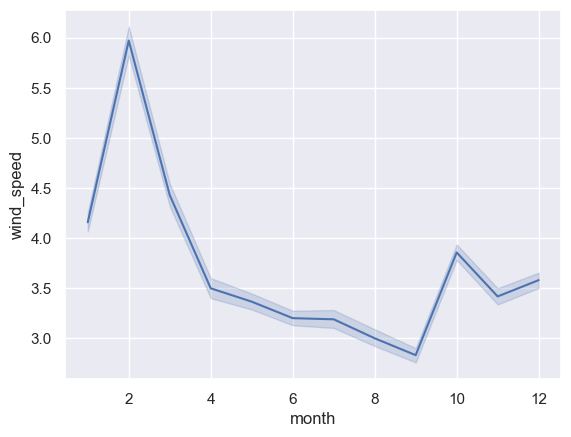

In [26]:
#? clean the data for month before?
sns.lineplot(
    data=df_climate,
    x='month',
    y='wind_speed',
)
plt.show()

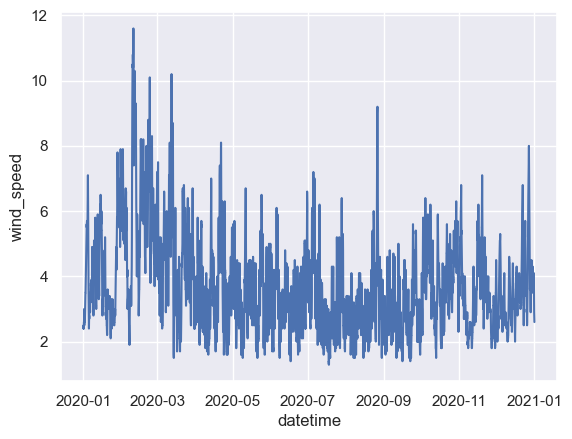

In [27]:
# wind speed day as x-axis
sns.lineplot(
    data=df_climate,
    x='datetime',
    y='wind_speed',
)
plt.show()

## Solar radiation in 2020

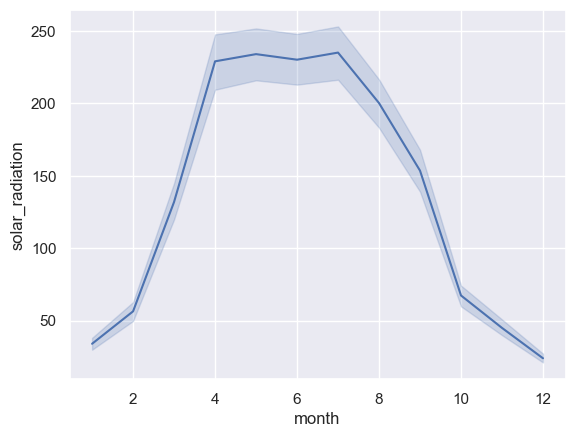

In [28]:
sns.lineplot(
    data=df_climate,
    x='month',
    y='solar_radiation'
)
plt.show()

## Combine energy data and climate data

In [29]:
# resample df_energy by day
df_energy_per_day = df_energy.copy()
df_energy_per_day.set_index('datetime', inplace=True)
#? take mean?
df_energy_per_day = df_energy_per_day.resample('D').agg({
    'nuclear_power': 'mean', 
    'not_renewable': 'mean',
    'renewable': 'mean',
    'energy_price': 'mean'
    })
df_energy_per_day = df_energy_per_day.reset_index()
df_energy_per_day = df_energy_per_day.rename(columns={'datetime': 'date'})
df_energy_per_day.head()

,date,nuclear_power,not_renewable,renewable,energy_price
0,2020-01-01,8044.976188,30977.572635,19176.814813,34.694167
1,2020-01-02,7994.833687,32666.177500,26297.153427,38.288750
2,2020-01-03,7659.783021,28310.728021,41045.319750,26.170833
3,2020-01-04,7539.419167,27804.281885,40908.875990,20.747917
4,2020-01-05,7971.458375,33010.196969,21967.765979,35.388333


In [30]:
# resample df_climate by day
df_climate_per_day = df_climate.copy()
df_climate_per_day.set_index('datetime', inplace=True)
#? take mean?
df_climate_per_day = df_climate_per_day.resample('D').agg({
    'wind_speed': 'mean', 
    'solar_radiation': 'mean',
})
df_climate_per_day = df_climate_per_day.reset_index()
df_climate_per_day = df_climate_per_day.rename(columns={'datetime': 'date'})
df_energy_per_day.head()

,date,nuclear_power,not_renewable,renewable,energy_price
0,2020-01-01,8044.976188,30977.572635,19176.814813,34.694167
1,2020-01-02,7994.833687,32666.177500,26297.153427,38.288750
2,2020-01-03,7659.783021,28310.728021,41045.319750,26.170833
3,2020-01-04,7539.419167,27804.281885,40908.875990,20.747917
4,2020-01-05,7971.458375,33010.196969,21967.765979,35.388333


In [31]:
df_energy_climate_combined = pd.merge(df_climate_per_day, df_energy_per_day) 
df_energy_climate_combined.head()

,date,wind_speed,solar_radiation,nuclear_power,not_renewable,renewable,energy_price
0,2020-01-01,2.620833,39.291667,8044.976188,30977.572635,19176.814813,34.694167
1,2020-01-02,3.308333,36.791667,7994.833687,32666.177500,26297.153427,38.288750
2,2020-01-03,5.279167,16.541667,7659.783021,28310.728021,41045.319750,26.170833
3,2020-01-04,5.891667,17.083333,7539.419167,27804.281885,40908.875990,20.747917
4,2020-01-05,2.991667,30.625000,7971.458375,33010.196969,21967.765979,35.388333


## Correlation of energy and climate
- wind speed and renewable energy have high correlation
- wind speed and energy price have negative correlation

In [32]:
df_energy_climate_combined.corr(numeric_only=True)

,wind_speed,solar_radiation,nuclear_power,not_renewable,renewable,energy_price
wind_speed,1.000000,-0.350693,-0.009918,-0.428294,0.899298,-0.532878
solar_radiation,-0.350693,1.000000,-0.473372,-0.428355,-0.117477,-0.313121
nuclear_power,-0.009918,-0.473372,1.000000,0.422500,-0.112010,0.403976
not_renewable,-0.428294,-0.428355,0.422500,1.000000,-0.590773,0.864644
renewable,0.899298,-0.117477,-0.112010,-0.590773,1.000000,-0.642079
energy_price,-0.532878,-0.313121,0.403976,0.864644,-0.642079,1.000000


In [33]:
# imports
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
%matplotlib inline

In [34]:
# resample the combined df by month
df_energy_climate_combined.set_index('date', inplace=True)
combined_per_month = df_energy_climate_combined.resample('M').mean()
combined_per_month.reset_index(inplace=True)
combined_per_month

,date,wind_speed,solar_radiation,nuclear_power,not_renewable,renewable,energy_price
0,2020-01-31,4.155108,34.024194,7807.641693,40108.081534,30550.649508,34.978710
1,2020-02-29,5.970690,56.419540,7419.751695,29840.861220,39375.945443,21.911839
2,2020-03-31,4.426747,131.969086,7266.131540,31178.614326,32605.582938,22.519315
3,2020-04-30,3.495417,229.087500,6561.627329,24050.886692,29070.825843,17.049194
4,2020-05-31,3.361694,234.065860,5762.919882,24769.446723,27092.300725,17.604879
5,2020-06-30,3.197083,230.220833,6463.409776,29899.843443,24925.065740,26.229167
6,2020-07-31,3.185484,235.129032,5687.576221,30833.884795,26203.010712,30.074946
7,2020-08-31,2.995833,200.256720,7521.303469,34069.302622,24342.192233,34.889704
8,2020-09-30,2.827222,153.597222,7349.898565,37079.136104,23241.985196,43.678097
9,2020-10-31,3.853629,67.380376,6892.146856,36540.185486,29493.414200,33.955901


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


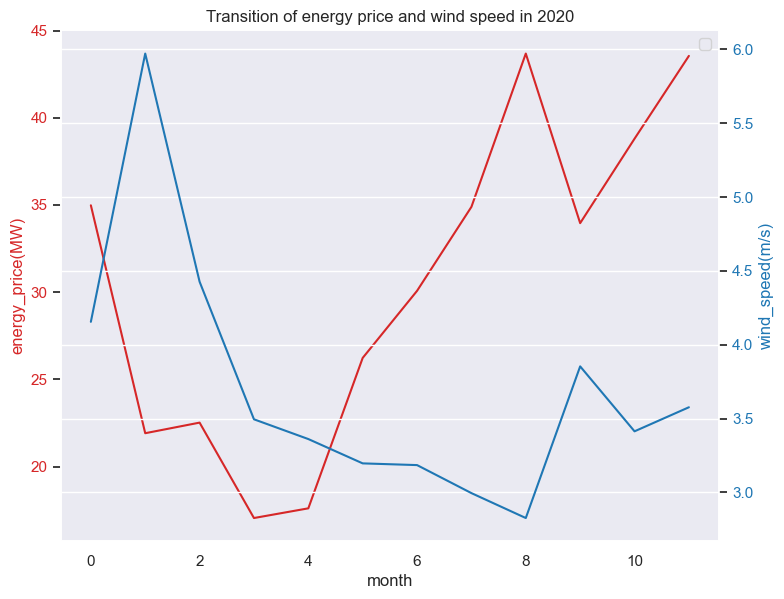

In [35]:
# plot energy price and wind speed in one graph
fig, ax1 = plt.subplots(figsize=(8, 6))

# disable grid of ax1 so that we don't get two grids
ax1.grid(False)

# energy_price
color_1 = 'tab:red'
ax1.set_xlabel('month')
ax1.set_ylabel('energy_price(MW)', color=color_1)
ax1.plot(
    combined_per_month['energy_price'],
    color = color_1
)

# wind_speed
ax2 = ax1.twinx()
color_2 = 'tab:blue'
ax2.set_ylabel('wind_speed(m/s)', color=color_2)
ax2.plot(
     combined_per_month['wind_speed'],
     color=color_2
)

# change label color
ax1.tick_params(axis='y', labelcolor=color_1)
ax2.tick_params(axis='y', labelcolor=color_2)

# rotate x-axis
ax2.tick_params(axis='x', rotation=45)

# adjust subplot params so that the subplots fits in to the figure area
fig.tight_layout()


plt.title('Transition of energy price and wind speed in 2020')
#? legend?
plt.legend()
plt.show()

## Exponential Smoothing

#### Holt-Winters model
- has Trend
- has Seasonality
- Not random

In [36]:
# Exponential smoothing
sr_exp_smoothing = df_energy.copy()
sr_exp_smoothing.set_index('datetime', inplace=True)
# resample the data - take day as unit(use mean value)
sr_exp_smoothing = sr_exp_smoothing['energy_price'].resample(rule='D').mean()

<AxesSubplot: xlabel='datetime'>

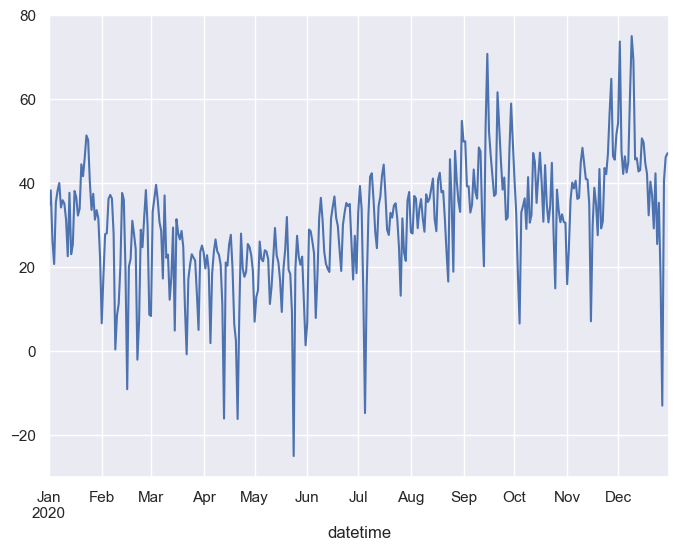

In [37]:
# set figure size
rcParams['figure.figsize'] = 8,6
# plot
sr_exp_smoothing.plot()

In [38]:
# Build a model
model = ExponentialSmoothing(endog=sr_exp_smoothing).fit()

In [39]:
# create prediction for 60 days
predictions = model.forecast(60)

<AxesSubplot: xlabel='datetime'>

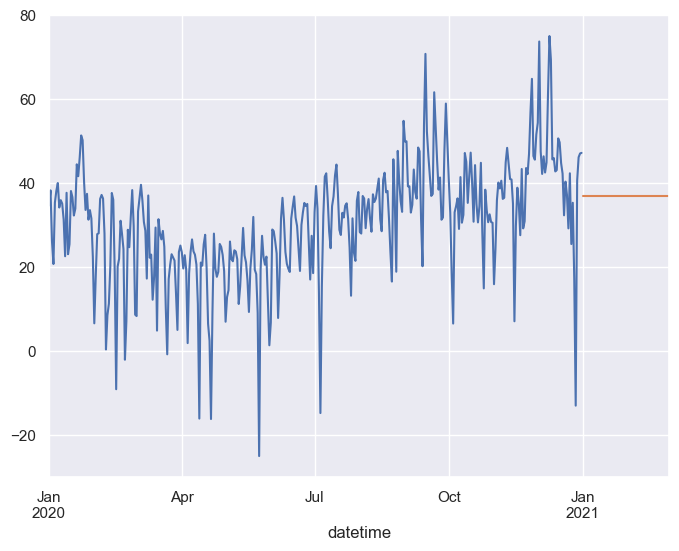

In [40]:
# set figure size
sr_exp_smoothing.plot(figsize = (8, 6))
# Plot predictions
predictions.plot()